In [3]:
import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    fbeta_score,
)

df = pd.read_csv("../stats/combined.csv")
X = df.drop(["chr", "start", "end", "cnv_type", "BAM_CREF_SKIP", "BAM_CSOFT_CLIP", "BAM_CHARD_CLIP", "BAM_CPAD", "BAM_CEQUAL", "BAM_CDIFF", "BAM_CBACK", "med", "overlap", "intq", "NM tag"], axis=1)
lbl_e = LabelEncoder()
y = lbl_e.fit_transform(df["cnv_type"])

# Podział na zbiór treningowy i testowy
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
df

,chr,start,end,overlap,intq,means,std,med,BAM_CMATCH,BAM_CINS,BAM_CDEL,BAM_CREF_SKIP,BAM_CSOFT_CLIP,BAM_CHARD_CLIP,BAM_CPAD,BAM_CEQUAL,BAM_CDIFF,BAM_CBACK,NM tag,cnv_type
0,1,1,50,0.0,0.00,0.000000,0.000000,0.0,0,0,0,0,0,0,0,0,0,0,0,normal
1,1,51,100,0.0,0.00,0.000000,0.000000,0.0,0,0,0,0,0,0,0,0,0,0,0,normal
2,1,101,150,61.0,0.25,1.244898,0.430027,1.0,302,0,0,0,0,0,0,0,0,0,1,normal
3,1,151,200,124.0,0.50,2.530612,0.499062,3.0,453,0,0,0,0,0,0,0,0,0,1,normal
4,1,201,250,147.0,0.50,2.897959,0.302702,3.0,453,0,0,0,0,0,0,0,0,0,1,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14880418,13,208334301,208334350,219.0,0.75,4.122449,0.658776,4.0,1057,0,0,0,0,0,0,0,0,0,0,normal
14880419,13,208334351,208334400,215.0,0.75,4.122449,0.627032,4.0,755,0,0,0,0,0,0,0,0,0,0,normal
14880420,13,208334401,208334450,219.0,0.50,4.367347,0.873508,5.0,755,0,0,0,0,0,0,0,0,0,0,normal
14880421,13,208334451,208334500,112.0,0.25,2.285714,0.534522,2.0,453,0,0,0,0,0,0,0,0,0,0,normal


In [26]:
label_mapping = {original_label: encoded_label for original_label, encoded_label in zip(df["cnv_type"], y)}


In [27]:
label_mapping

{'normal': 2, 'dup': 1, 'del': 0}

In [ ]:
#Define the objective function to optimize
results = []
def objective(trial):
    # Define the hyperparameters to search over
    model_type = trial.suggest_categorical('model_type', ['RandomForest', 'LightGBM', 'XGBoost'])
    n_estimators = trial.suggest_int('n_estimators', 10, 100, step=10)
    max_depth = trial.suggest_int('max_depth', 10, 100, step=10)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced', {0: 1, 1: 3, 2: 3}])
    log_transform = trial.suggest_categorical('log_transform', [True, False])
    standard_scaler = trial.suggest_categorical('standard_scaler', [True, False])
    undersampling = trial.suggest_categorical('undersampling', [True, False])

    # Preprocess the data based on hyperparameters
    if undersampling:
        # Undersampling klas mniejszościowych (przykład)
        count = Counter(y_train)
        classes_resampling = {2: int(count[2] * 0.3)}
        under = RandomUnderSampler(
            sampling_strategy=classes_resampling, random_state=42
        )
        X_res, y_res = under.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train

    if standard_scaler:
        scaler = StandardScaler()
        X_res = scaler.fit_transform(X_res)
        x_test_res = scaler.transform(x_test)
    
    if log_transform:
        X_res = np.log1p(X_res)
        x_test_res = np.log1p(x_test)


    if model_type == 'RandomForest':
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight=class_weight, random_state=42, n_jobs=-1)
    elif model_type == 'LightGBM':
        model = LGBMClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight=class_weight, random_state=42, n_jobs=-1)
    elif model_type == 'XGBoost':
        model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, scale_pos_weight=class_weight, random_state=42, n_jobs=-1)


    # Trenowanie modelu
    model.fit(X_res, y_res)

    # Przewidywanie na zbiorze testowym
    if standard_scaler or log_transform:
        y_pred = model.predict(x_test_res)
    else:
        y_pred = model.predict(x_test)
    fbeta = fbeta_score(y_test, y_pred, beta = 3, average='macro')


    results.append({
        'model': model_type,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'class_weight': class_weight,
        'log_transform': log_transform,
        'standard_scaler': standard_scaler,
        'undersampling': undersampling,
        'fbeta': fbeta,
        'classification_report': classification_report(y_test, y_pred, zero_division=True),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    })

    return fbeta

# Load your data and preprocess it
# ...

# Split the data into training and testing sets
# ...

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # You can adjust the number of trials

# Get the best hyperparameters
best_params = study.best_params
best_accuracy = study.best_value

print("Najlepsze hiperparametry:")
print(best_params)
print("Najlepsza dokładność:", best_accuracy)


In [ ]:
pd.DataFrame(results).to_csv("results.csv", index=False)

## Load hyperparam search results and analyze them

In [5]:
df_res = pd.read_csv('results.csv')

In [53]:
df_res_sorted = df_res.sort_values(by=['fbeta'], ascending=False)

In [54]:
df_res_sorted

,model,n_estimators,max_depth,class_weight,log_transform,standard_scaler,undersampling,fbeta,classification_report,confusion_matrix
33,LightGBM,60,50,NaN,True,False,True,0.883837,precision recall f1-score ...,[[ 252942 92 822]\n [ 27 188085 ...
32,LightGBM,60,50,NaN,True,False,True,0.883837,precision recall f1-score ...,[[ 252942 92 822]\n [ 27 188085 ...
31,LightGBM,60,50,NaN,True,False,True,0.883837,precision recall f1-score ...,[[ 252942 92 822]\n [ 27 188085 ...
30,LightGBM,60,50,NaN,True,False,True,0.883837,precision recall f1-score ...,[[ 252942 92 822]\n [ 27 188085 ...
43,LightGBM,60,50,NaN,True,False,True,0.883837,precision recall f1-score ...,[[ 252942 92 822]\n [ 27 188085 ...
42,LightGBM,60,40,NaN,True,False,True,0.883837,precision recall f1-score ...,[[ 252942 92 822]\n [ 27 188085 ...
46,LightGBM,50,40,NaN,True,False,True,0.883834,precision recall f1-score ...,[[ 252940 92 824]\n [ 27 188085 ...
44,LightGBM,40,30,NaN,True,False,True,0.883832,precision recall f1-score ...,[[ 252939 92 825]\n [ 27 188080 ...
15,LightGBM,80,40,NaN,True,False,True,0.883829,precision recall f1-score ...,[[ 252941 92 823]\n [ 28 188084 ...
27,LightGBM,80,60,NaN,True,False,True,0.883829,precision recall f1-score ...,[[ 252941 92 823]\n [ 28 188084 ...


## Train model with best hyperparameters and save it

In [4]:
best_model = df_res_sorted.iloc[0]

NameError: name 'df_res_sorted' is not defined

In [64]:
model = LGBMClassifier(n_estimators=60, max_depth=50, class_weight=None, random_state=42, n_jobs=-1, num_leaves=50)

In [97]:
count = Counter(y_train)
classes_resampling = {2: int(count[2] * 0.3)}
under = RandomUnderSampler(
    sampling_strategy=classes_resampling, random_state=42
)
X_res, y_res = under.fit_resample(X_train, y_train)

In [98]:
X_res = np.log1p(X_res)
x_test_res = np.log1p(x_test)

In [65]:
model.fit(X_res, y_res)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1765
[LightGBM] [Info] Number of data points in the train set: 4004094, number of used features: 9
[LightGBM] [Info] Start training from score -1.369557
[LightGBM] [Info] Start training from score -1.358792
[LightGBM] [Info] Start training from score -0.715783


LGBMClassifier(max_depth=50, n_estimators=60, n_jobs=-1, num_leaves=50,
               random_state=42)

In [67]:
y_pred = model.predict(x_test_res)

In [72]:
y_train_pred = model.predict(X_train)

In [74]:
fbeta_score(y_test, y_pred, beta = 3, average='macro')

0.8838423859988046

In [75]:
confusion_matrix(y_train, y_train_pred)

array([[1013838,     960,    3121],
       [    118,  968479,   60339],
       [  75647, 3309119, 3139364]])

In [78]:
print(classification_report(y_train, y_train_pred, zero_division=True))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96   1017919
           1       0.23      0.94      0.36   1028936
           2       0.98      0.48      0.65   6524130

    accuracy                           0.60   8570985
   macro avg       0.71      0.81      0.66   8570985
weighted avg       0.88      0.60      0.65   8570985



In [79]:
gain_importances = model.booster_.feature_importance(importance_type='gain')  # Gain feature importance


In [91]:
gain_importances * 0.001

array([1.80975331e+04, 2.18102658e+00, 3.03817211e+02, 1.02667584e+01,
       4.14035126e+00, 1.44790237e+04, 1.37547944e+00, 6.83395563e-01,
       3.10461044e+00])

In [81]:
split_importances = model.feature_importances_  # Split feature importance


In [82]:
split_importances

array([1227,  327,  762, 1796,  339, 3222,  198,  147,  802], dtype=int32)

In [83]:
X.columns

Index(['overlap', 'intq', 'means', 'std', 'med', 'BAM_CMATCH', 'BAM_CINS',
       'BAM_CDEL', 'NM tag'],
      dtype='object')

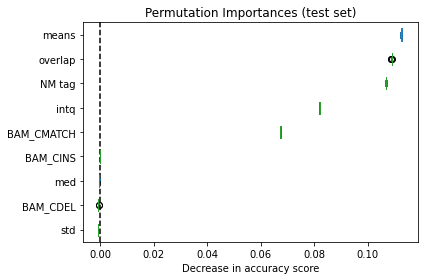

In [111]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    model, x_test, y_test, n_repeats=30, random_state=42, n_jobs=10
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()


In [112]:
importances

,std,BAM_CDEL,med,BAM_CINS,BAM_CMATCH,intq,NM tag,overlap,means
0,-0.000688,-0.000583,-0.000207,0.000000e+00,0.067558,0.082326,0.106953,0.109166,0.112696
1,-0.000664,-0.000585,-0.000202,0.000000e+00,0.067732,0.082264,0.107114,0.109145,0.112543
2,-0.000701,-0.000620,-0.000214,4.666907e-07,0.067132,0.082326,0.107197,0.108779,0.112962
3,-0.000668,-0.000634,-0.000209,-4.666907e-07,0.067434,0.081922,0.106566,0.109107,0.112366
4,-0.000696,-0.000576,-0.000202,4.666907e-07,0.067341,0.082051,0.106879,0.109091,0.112726
5,-0.000671,-0.000624,-0.000239,4.666907e-07,0.067287,0.081815,0.106643,0.108901,0.112383
6,-0.000684,-0.000632,-0.000206,4.666907e-07,0.067413,0.082238,0.107089,0.109004,0.112644
7,-0.000646,-0.000609,-0.000227,0.000000e+00,0.067652,0.082002,0.106893,0.109328,0.112332
8,-0.000697,-0.000651,-0.000222,0.000000e+00,0.067303,0.082089,0.107163,0.109045,0.112778
9,-0.000695,-0.000619,-0.000239,4.666907e-07,0.067765,0.081944,0.106860,0.109180,0.112811


In [101]:
rf_best_model_spec = df_res[df_res['model'] == 'RandomForest'].sort_values(by=['fbeta'], ascending=False).iloc[0]
rf_model = RandomForestClassifier(n_estimators=rf_best_model_spec["n_estimators"], max_depth=rf_best_model_spec["max_depth"], class_weight=None, random_state=42, n_jobs=-1)

In [102]:
rf_model.fit(X_res, y_res)

RandomForestClassifier(max_depth=30, n_estimators=60, n_jobs=-1,
                       random_state=42)

In [104]:
from plots import plot_feature_importances

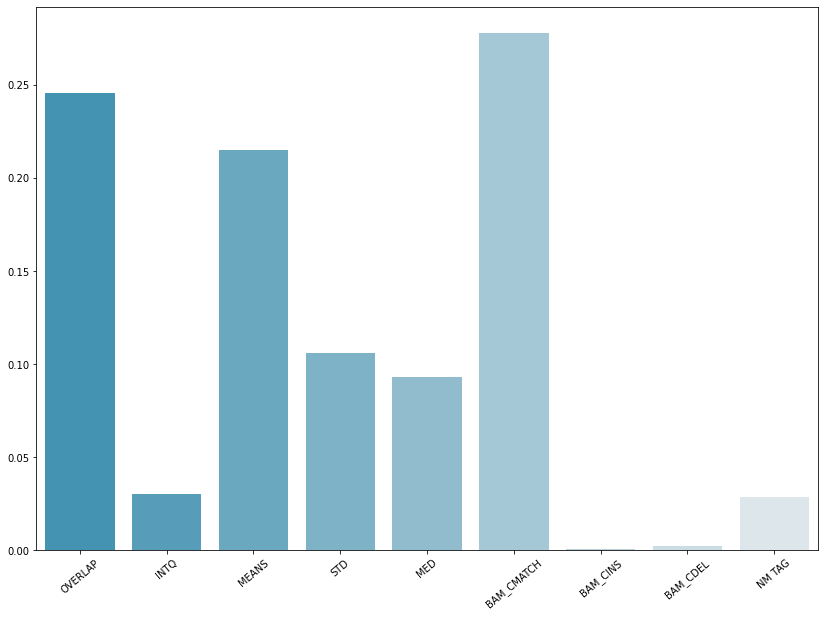

In [113]:
plot_feature_importances(X.columns, rf_model.feature_importances_)

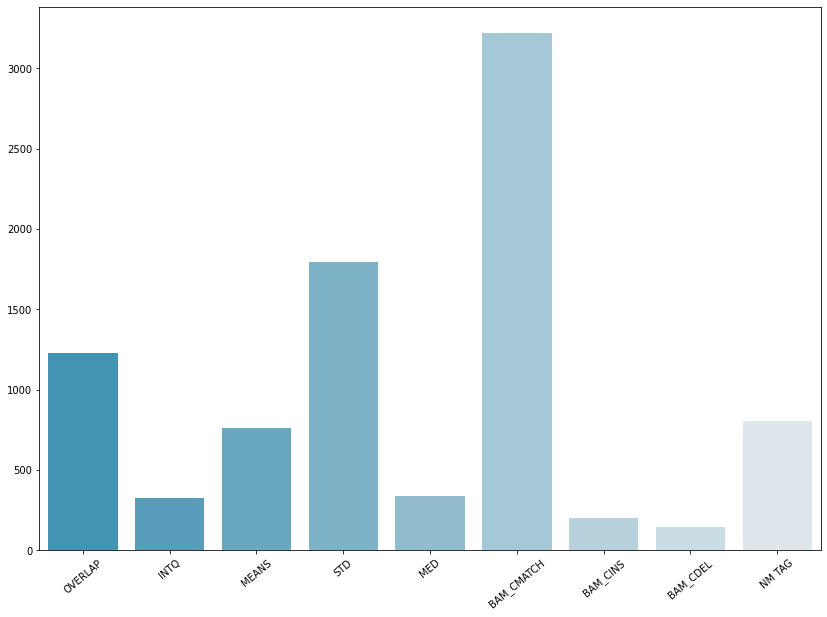

In [114]:
plot_feature_importances(X.columns, model.feature_importances_)

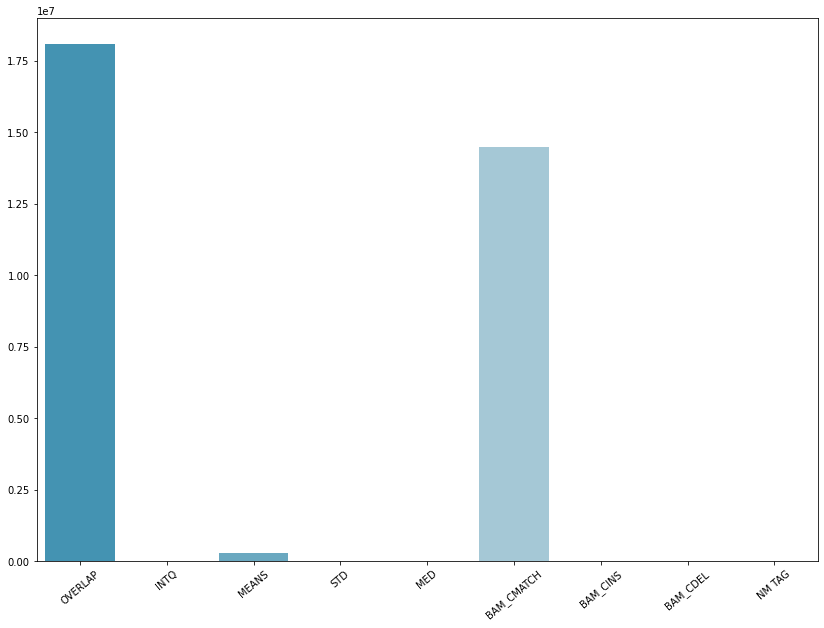

In [108]:
plot_feature_importances( X.columns, model.booster_.feature_importance(importance_type='gain'))

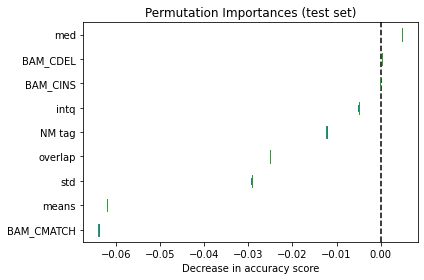

In [115]:
result = permutation_importance(
    rf_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=10
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()